## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

In [3]:
import pickle
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.get_statistics import *
from model_scripts.dataset_creation import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from evaluation_scripts.label_helper import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

# Test 1: Temporal vs Non-temporal Data

## Temporal Data

### Loading the pre-processed temporal data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field) - Temporal Images (stack size 7)

Dimensions: (N, T, C, H, W) = (N, 7, 10, 64, 64)

In [30]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, patch_tensor_train, visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'allbands')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'allbands')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([2425, 7, 10, 64, 64]), torch.Size([48, 7, 10, 64, 64]))

### Create Sub-Patches

In [7]:
train_subpatches, train_subpatch_coords = non_overlapping_sliding_window(patch_tensor_train, field_numbers_train, patch_size=config.subpatch_size)
eval_subpatches, eval_subpatch_coords = non_overlapping_sliding_window(patch_tensor_eval, field_numbers_eval, patch_size=config.subpatch_size)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([39042, 7, 10, 5, 5]), torch.Size([867, 7, 10, 5, 5]))

### Modeling: k-means

Clustering the sub-patches 

In [8]:
kmeans = train_kmeans_patches(train_subpatches, n_clusters=2, random_state=1)

train_subpatch_predictions = kmeans.predict(train_subpatches.reshape(train_subpatches.size(0), -1).numpy())
test_subpatch_predictions = kmeans.predict(eval_subpatches.reshape(eval_subpatches.size(0), -1).numpy())

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Evaluation

Assigning field-level labels: Converting subpatch-level labels to field-level labels using a threshold

In [9]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels(train_subpatch_coords, train_subpatch_predictions, threshold)
test_field_labels = assign_field_labels(eval_subpatch_coords, test_subpatch_predictions, threshold)

Accuracy on field-level labels: Compare with the Ground Truth

In [10]:
accuracy, report, cm = evaluate_test_labels(test_field_labels, config.labels_path)
print(f"Test Accuracy: {accuracy}")
print(report)
print(cm)

Test Accuracy: 0.639344262295082
              precision    recall  f1-score   support

           0       0.75      0.23      0.35        26
           1       0.62      0.94      0.75        35

    accuracy                           0.64        61
   macro avg       0.69      0.59      0.55        61
weighted avg       0.68      0.64      0.58        61

[[ 6 20]
 [ 2 33]]


### Visualise a field

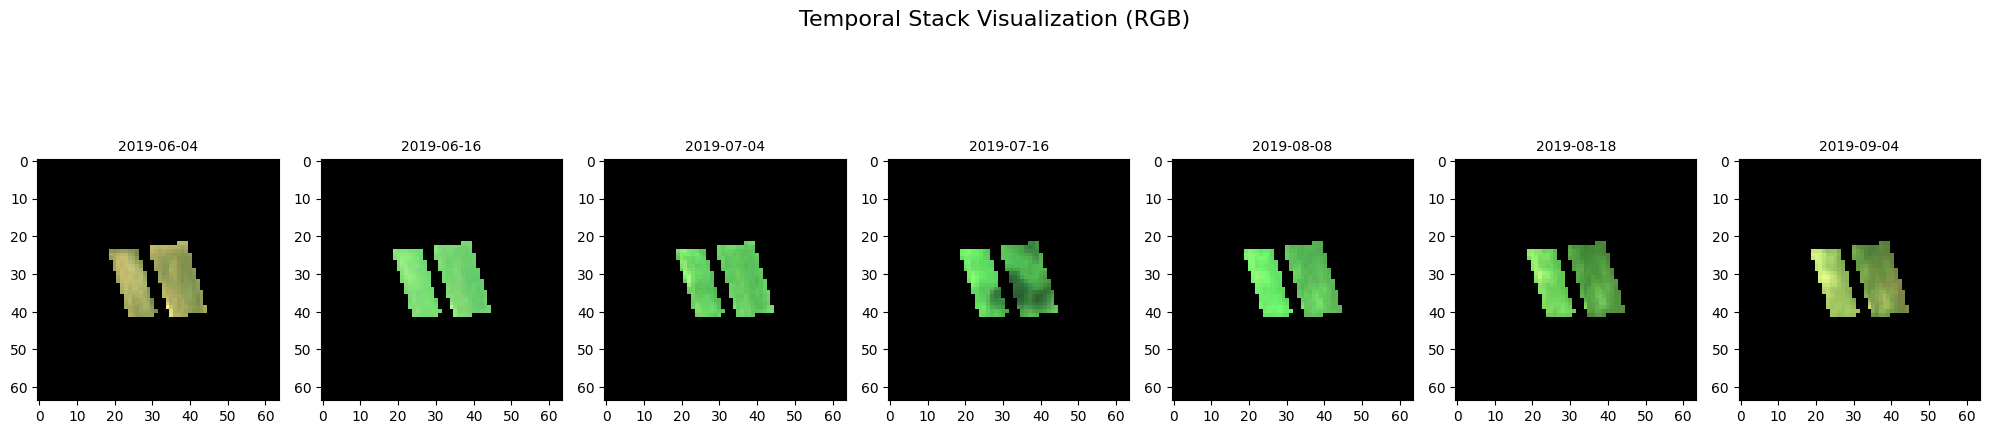

In [77]:
visualize_temporal_stack_rgb(visualisation_eval[26], acquisition_dates_eval[field_numbers_eval[26]])

In [79]:
field_numbers_eval[26]

'1216801.0_1216804.0'

## Non-temporal Data

### Load non-temporal images

Data: Extracted and Pre-processed Patches, with a single temporal image from September

Dimensions: (N, C, H, W) = (N, 10, 64, 64)

In [32]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train_nt, acquisition_dates_train_nt, patch_tensor_train_nt, visualisation_train_nt = preprocessing_pipeline.get_processed_non_temporal_data('train', 'allbands')
field_numbers_eval_nt, acquisition_dates_eval_nt, patch_tensor_eval_nt, visualisation_eval_nt = preprocessing_pipeline.get_processed_non_temporal_data('eval', 'allbands')
patch_tensor_train_nt.shape, patch_tensor_eval_nt.shape

(torch.Size([2425, 10, 64, 64]), torch.Size([48, 10, 64, 64]))

### Create Sub-Patches

In [12]:
train_subpatches_nt, train_subpatch_coords_nt = non_overlapping_sliding_window_non_temporal(patch_tensor_train_nt, field_numbers_train_nt, patch_size=config.subpatch_size)
eval_subpatches_nt, eval_subpatch_coords_nt = non_overlapping_sliding_window_non_temporal(patch_tensor_eval_nt, field_numbers_eval_nt, patch_size=config.subpatch_size)
train_subpatches_nt.shape, eval_subpatches_nt.shape

(torch.Size([39042, 10, 5, 5]), torch.Size([867, 10, 5, 5]))

### Modeling: k-means

Clustering the sub-patches 

In [19]:
kmeans_nt = train_kmeans_patches(train_subpatches_nt, n_clusters=2, random_state=11)

train_subpatch_predictions_nt = kmeans_nt.predict(train_subpatches_nt.reshape(train_subpatches_nt.size(0), -1).numpy())
eval_subpatch_predictions_nt = kmeans_nt.predict(eval_subpatches_nt.reshape(eval_subpatches_nt.size(0), -1).numpy())

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Evaluation

Assigning field-level labels: Converting subpatch-level labels to field-level labels using a threshold

In [20]:
threshold = config.patch_to_field_threshold
train_field_labels_nt = assign_field_labels(train_subpatch_coords_nt, train_subpatch_predictions_nt, threshold)
eval_field_labels_nt = assign_field_labels(eval_subpatch_coords_nt, eval_subpatch_predictions_nt, threshold)

Accuracy on field-level labels: Compare with the Ground Truth

In [21]:
accuracy_nt, report_nt, cm_nt = evaluate_test_labels(eval_field_labels_nt, config.labels_path)
print(f"Test Accuracy: {accuracy_nt}")
print(report_nt)
print("Confusion Matrix:\n", cm_nt)

Test Accuracy: 0.3770491803278688
              precision    recall  f1-score   support

           0       0.37      0.65      0.47        26
           1       0.40      0.17      0.24        35

    accuracy                           0.38        61
   macro avg       0.38      0.41      0.36        61
weighted avg       0.39      0.38      0.34        61

Confusion Matrix:
 [[17  9]
 [29  6]]


### Visualise a field

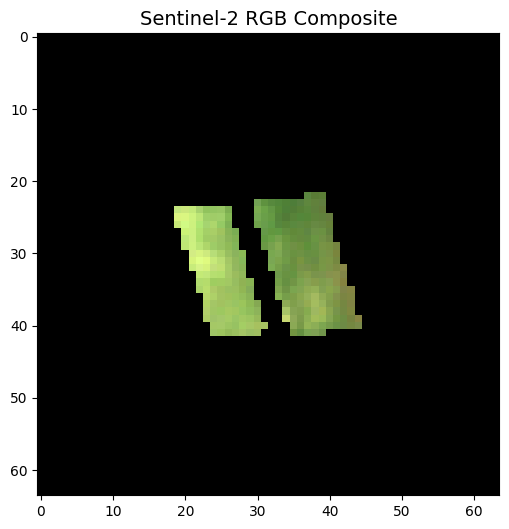

In [78]:
visualise_rgb(visualisation_eval_nt[26])

# Test 2: Patch Level vs Sub-patch Level Clustering

## Patch-level Clustering

### Loading the pre-processed temporal data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field) - Temporal Images (stack size 7)

Dimensions: (N, T, C, H, W) = (N, 7, 10, 64, 64)

In [5]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, patch_tensor_train, visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'allbands')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'allbands')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([2425, 7, 10, 64, 64]), torch.Size([48, 7, 10, 64, 64]))

### Create Patch-level Data Loaders (for Auto-encoders)

In [6]:
train_patches_dl, test_patches, train_field_numbers, test_field_numbers = train_test_split(
    patch_tensor_train, field_numbers_train, test_size=1-0.75, random_state=40
)

dataloader_train = create_data_loader(train_patches_dl, train_field_numbers, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader(test_patches, test_field_numbers, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader(patch_tensor_eval, field_numbers_eval, batch_size=config.ae_batch_size, shuffle=False)

/home/k64835/Master-Thesis-SITS/Modeling/model_scripts/dataset_creation.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 2, 1, 3, 4)  # (N, T, C, H, W) -> (N, C, T, H, W)


### Modeling: k-means

Clustering the Patches

In [7]:
kmeans_b10 = train_kmeans_patches(patch_tensor_train, n_clusters=2, random_state=12)

train_patch_predictions = kmeans_b10.predict(patch_tensor_train.reshape(patch_tensor_train.size(0), -1).numpy())
eval_patch_predictions = kmeans_b10.predict(patch_tensor_eval.reshape(patch_tensor_eval.size(0), -1).numpy())

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Evaluation

Accuracy on field-level labels: Compare with the Ground Truth

In [8]:
accuracy, report, cm, pred_aligned, gt_aligned = get_accuracy(field_numbers_eval, eval_patch_predictions, config.labels_path)
print(f"Test Accuracy: {accuracy}")
print(report)
print(cm)

Test Accuracy: 0.5645161290322581
              precision    recall  f1-score   support

           0       0.50      0.62      0.55        26
           1       0.66      0.54      0.59        35

    accuracy                           0.57        61
   macro avg       0.58      0.58      0.57        61
weighted avg       0.59      0.57      0.58        61

[[16 10]
 [16 19]]


### Visualise a Patch

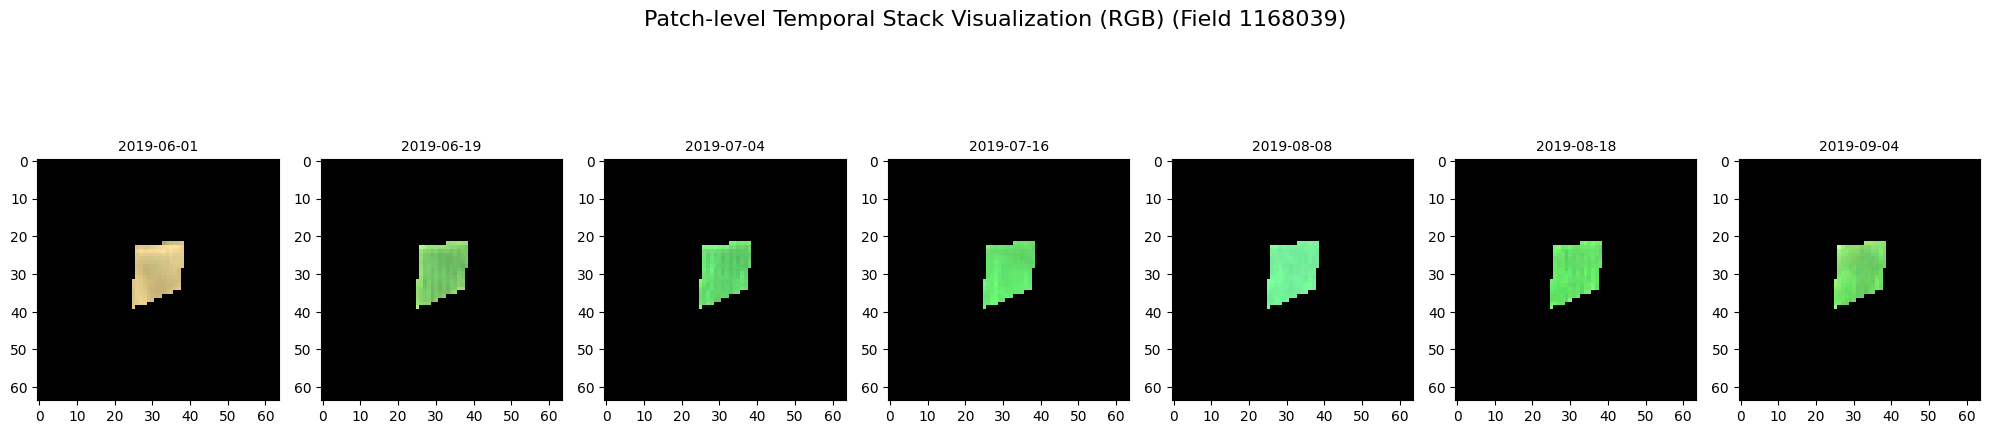

In [37]:
visualize_temporal_stack_rgb(visualisation_eval[0], acquisition_dates_eval[field_numbers_eval[0]])

In [20]:
field_numbers_eval[0]

'1168039.0'

## Subpatch-level Clustering

### Loading the pre-processed temporal data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field) - Temporal Images (stack size 7)

Dimensions: (N, T, C, H, W) = (N, 7, 10, 64, 64)

In [21]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, patch_tensor_train, visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'allbands')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'allbands')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([2425, 7, 10, 64, 64]), torch.Size([48, 7, 10, 64, 64]))

### Create Sub-Patches

In [25]:
train_subpatches, train_subpatch_coords = non_overlapping_sliding_window(patch_tensor_train, field_numbers_train, patch_size=config.subpatch_size)
eval_subpatches, eval_subpatch_coords = non_overlapping_sliding_window(patch_tensor_eval, field_numbers_eval, patch_size=config.subpatch_size)
train_subpatches.shape, eval_subpatches.shape

### Modeling: k-means

Clustering the sub-patches 

In [ ]:
kmeans = train_kmeans_patches(train_subpatches, n_clusters=2, random_state=12)

train_subpatch_predictions = kmeans.predict(train_subpatches.reshape(train_subpatches.size(0), -1).numpy())
test_subpatch_predictions = kmeans.predict(eval_subpatches.reshape(eval_subpatches.size(0), -1).numpy())

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Evaluation

Assigning field-level labels: Converting subpatch-level labels to field-level labels using a threshold

In [ ]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels(train_subpatch_coords, train_subpatch_predictions, threshold)
test_field_labels = assign_field_labels(eval_subpatch_coords, test_subpatch_predictions, threshold)

Accuracy on field-level labels: Compare with the Ground Truth

In [ ]:
accuracy, report, cm = evaluate_test_labels(test_field_labels, config.labels_path)
print(f"Test Accuracy: {accuracy}")
print(report)
print(cm)

Test Accuracy: 0.639344262295082
              precision    recall  f1-score   support

           0       0.75      0.23      0.35        26
           1       0.62      0.94      0.75        35

    accuracy                           0.64        61
   macro avg       0.69      0.59      0.55        61
weighted avg       0.68      0.64      0.58        61

[[ 6 20]
 [ 2 33]]


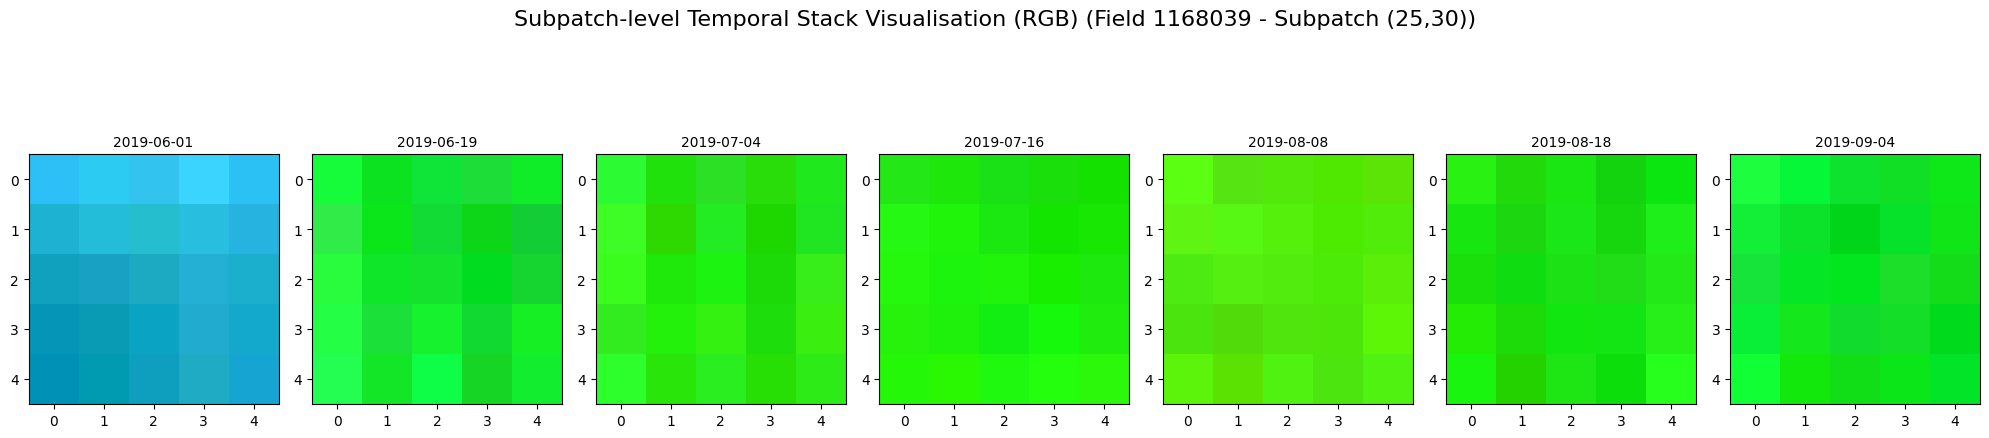

In [40]:
visualize_single_patch_temporal_rgb(eval_subpatches[4], eval_subpatch_coords[4], acquisition_dates_eval)

## Average height and width of sugarbeet fields

Load Temporal Field Patches without any pre-processing

In [13]:
temporal_images = load_field_images_temporal(config.load_directory_temporal_train)

Average Height and Width in Pixels

In [18]:
avg_h, avg_w = compute_avg_field_size_list(temporal_images)
print(f"Average Field Height: {avg_h:.2f}, Average Field Width: {avg_w:.2f}")

Average Field Height: 16.46, Average Field Width: 13.00


Average Height and Width on Earth's surface

(Sentinel 2 Images with all channels resized to 10 meter resolution)

In [17]:
pixel_size_m = 10 
avg_height_m = avg_h * pixel_size_m
avg_width_m = avg_w * pixel_size_m
print(f"Average Field Height (Earth Surface): {avg_height_m:.2f} meters, Average Field Width (Earth Surface): {avg_width_m:.2f} meters")

Average Field Height (Earth Surface): 164.63 meters, Average Field Width (Earth Surface): 130.00 meters
